In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import pandas as pd

In [2]:
npz = np.load('train.npz')
train_inputs = npz['inputs'].astype(float)
train_targets = npz['targets'].astype(int)

npz = np.load('validation.npz')
validation_inputs = npz['inputs'].astype(float)
validation_targets = npz['targets'].astype(int)

npz = np.load('test.npz')
test_inputs = npz['inputs'].astype(float)
test_targets = npz['targets'].astype(int)

In [3]:
train_inputs = train_inputs.reshape((train_inputs.shape[0], train_inputs.shape[1], 1))
test_inputs = test_inputs.reshape((test_inputs.shape[0], test_inputs.shape[1], 1))

In [4]:
num_classes = len(np.unique(train_targets))

In [5]:
idx = np.random.permutation(len(train_inputs))
train_inputs = train_inputs[idx]
train_targets = train_targets[idx]

In [6]:
test_targets=to_categorical(test_targets)
train_targets=to_categorical(train_targets)

In [7]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    
    conv1 = keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(input_layer)
    conv2 = keras.layers.Conv1D(filters=48, kernel_size=5, activation='relu', padding='same')(conv1)
    gap1 = keras.layers.GlobalAveragePooling1D()(conv2)
   
    
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap1)
    
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=train_inputs.shape[1:])
keras.utils.plot_model(model, show_shapes=True)
model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 120, 32)           192       
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 48)           7728      
                                                                 
 global_average_pooling1d (G  (None, 48)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 4)                 196       
                                            

In [8]:
epochs = 100
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
    "model_MCG_indoor.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=1000, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=1000, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_inputs,
    train_targets,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
3/3 [==============================] - 0s 69ms/step - loss: 1.3628 - accuracy: 0.2250 - val_loss: 1.3264 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 1.3203 - accuracy: 0.2375 - val_loss: 1.2860 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 1.2880 - accuracy: 0.2375 - val_loss: 1.2485 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - 0s 16ms/step - loss: 1.2577 - accuracy: 0.2375 - val_loss: 1.2142 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 1.2291 - accuracy: 0.2375 - val_loss: 1.1827 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 1.2003 - accuracy: 0.2375 - val_loss: 1.1556 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 7/100
3/3 [==============================] - 0s 18ms/step - loss: 1.1722 - a

In [9]:
model = keras.models.load_model("model_MCG_indoor.h5")

test_loss, test_acc = model.evaluate(test_inputs, test_targets)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

1/1 [==============================] - 0s 95ms/step - loss: 0.0113 - accuracy: 1.0000
Test accuracy 1.0
Test loss 0.011330355890095234


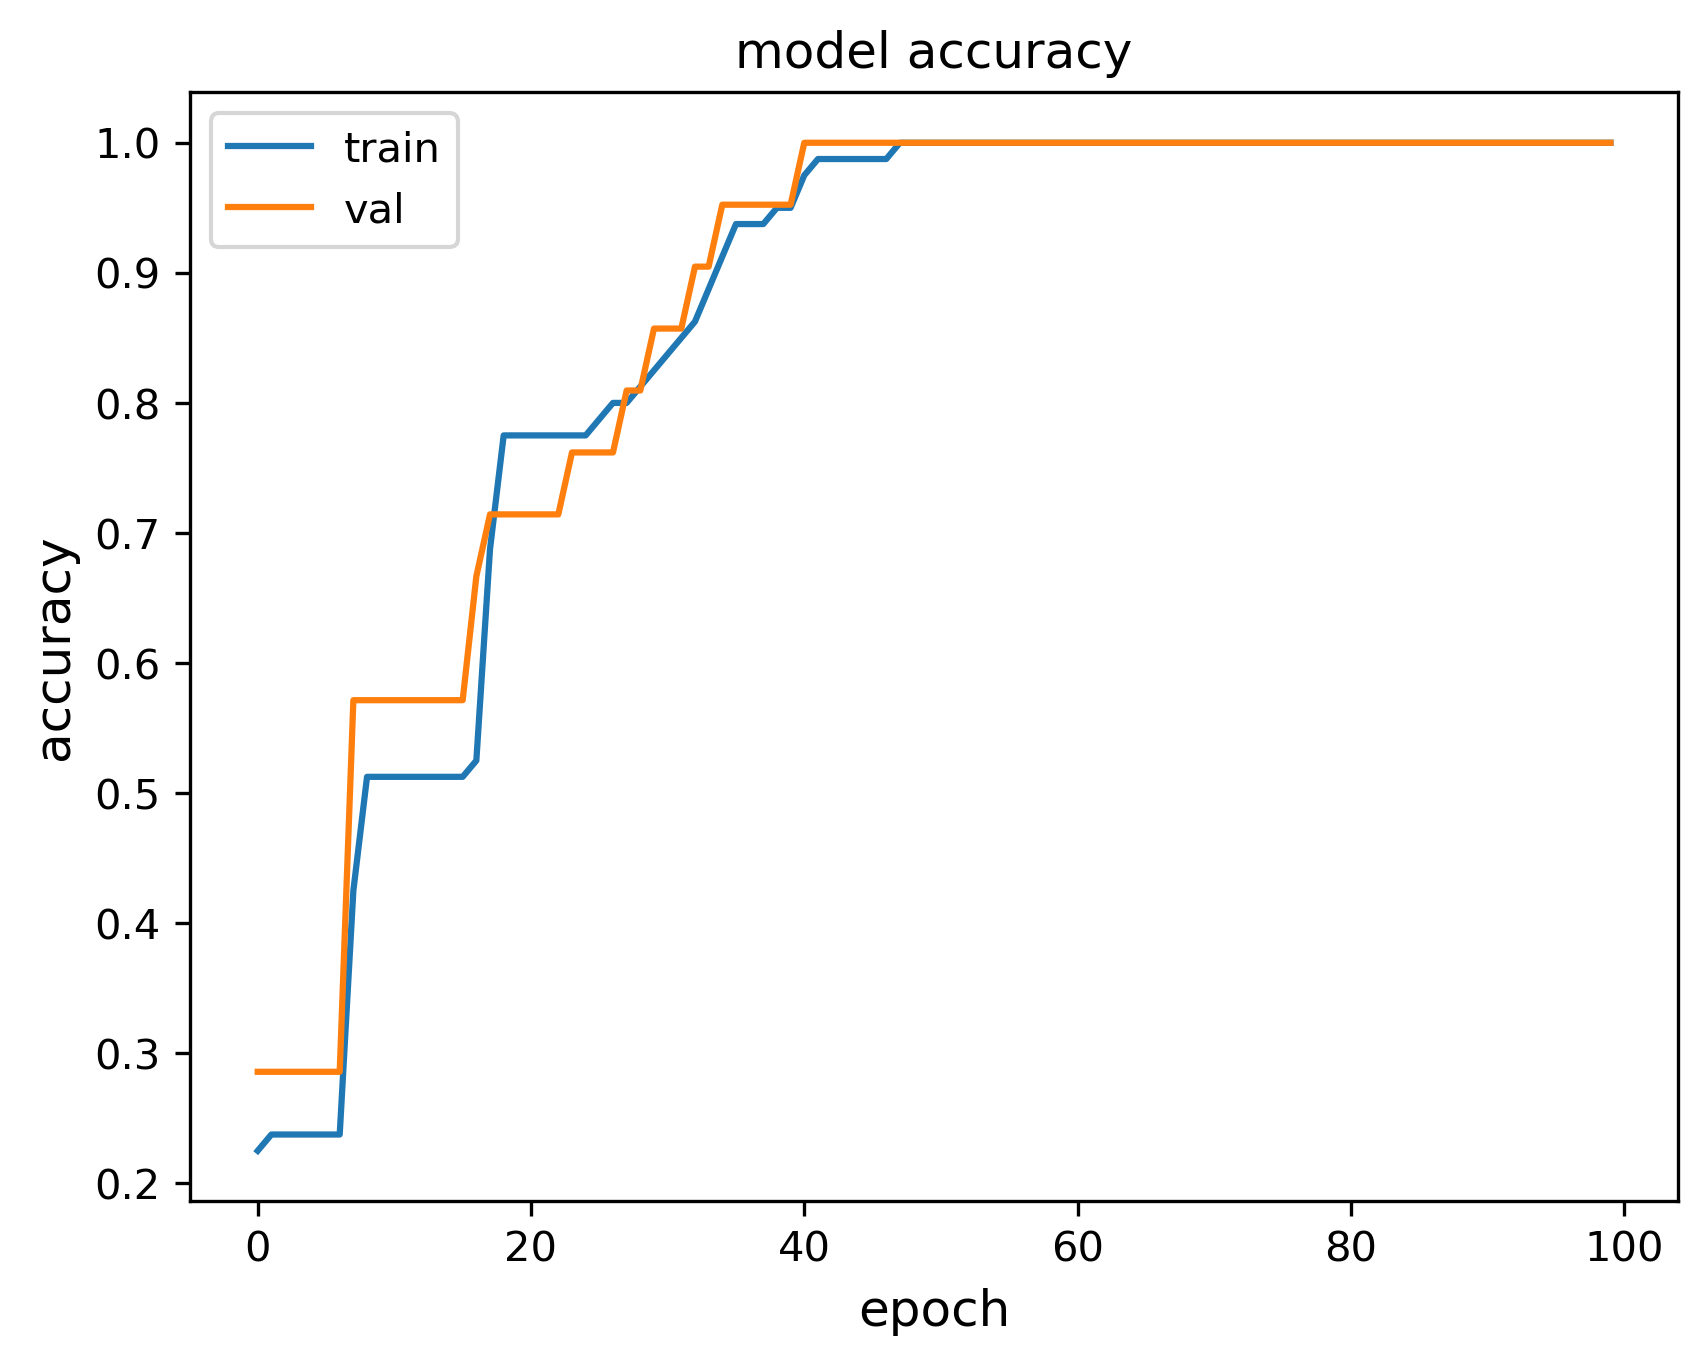

In [10]:
metric = "accuracy"
plt.figure(dpi=300)
plt.plot(history.history[metric])
plt.plot(history.history["val_"+ metric])
plt.title("model "+ metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [11]:
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from numpy import argmax
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [12]:
csv=np.loadtxt('Dataset\Dataset_totale.csv', delimiter=',')
data=pd.DataFrame(csv)
inp=np.array(data[data.columns[:-1]])
c = int(inp.shape[0]/20)
sc=load('std_scaler.bin')
all_input = np.empty([c, 120])
a1 = np.split(inp, c)
for i in range(c):
    a2 = a1[i].flatten()
    all_input[i] = a2
scaled_inp = sc.transform(all_input)
predictions = model.predict(
    scaled_inp,
    batch_size = 64,
    verbose=1,
    steps=None,
    #callbacks=callbacks,
)
y_pred=predictions.argmax(1)

2/2 [==============================] - 0s 3ms/step


In [13]:
targets=np.array(data[data.columns[-1]])
all_target = np.empty(c)
i=0
for j in range(0, inp.shape[0], 20):
    a3 = targets[j]
    all_target[i] = a3
    i=i+1
y_test=all_target

In [14]:
matrix = confusion_matrix(y_test, y_pred)

In [15]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(dpi=300)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
cm_plot_labels = ['Board ferma','Velocità bassa', 'Velocità media', 'Velocità elevata']

Confusion matrix, without normalization
[[40  0  0  0]
 [ 0 29  0  0]
 [ 0  0 29  0]
 [ 0  0  0 29]]


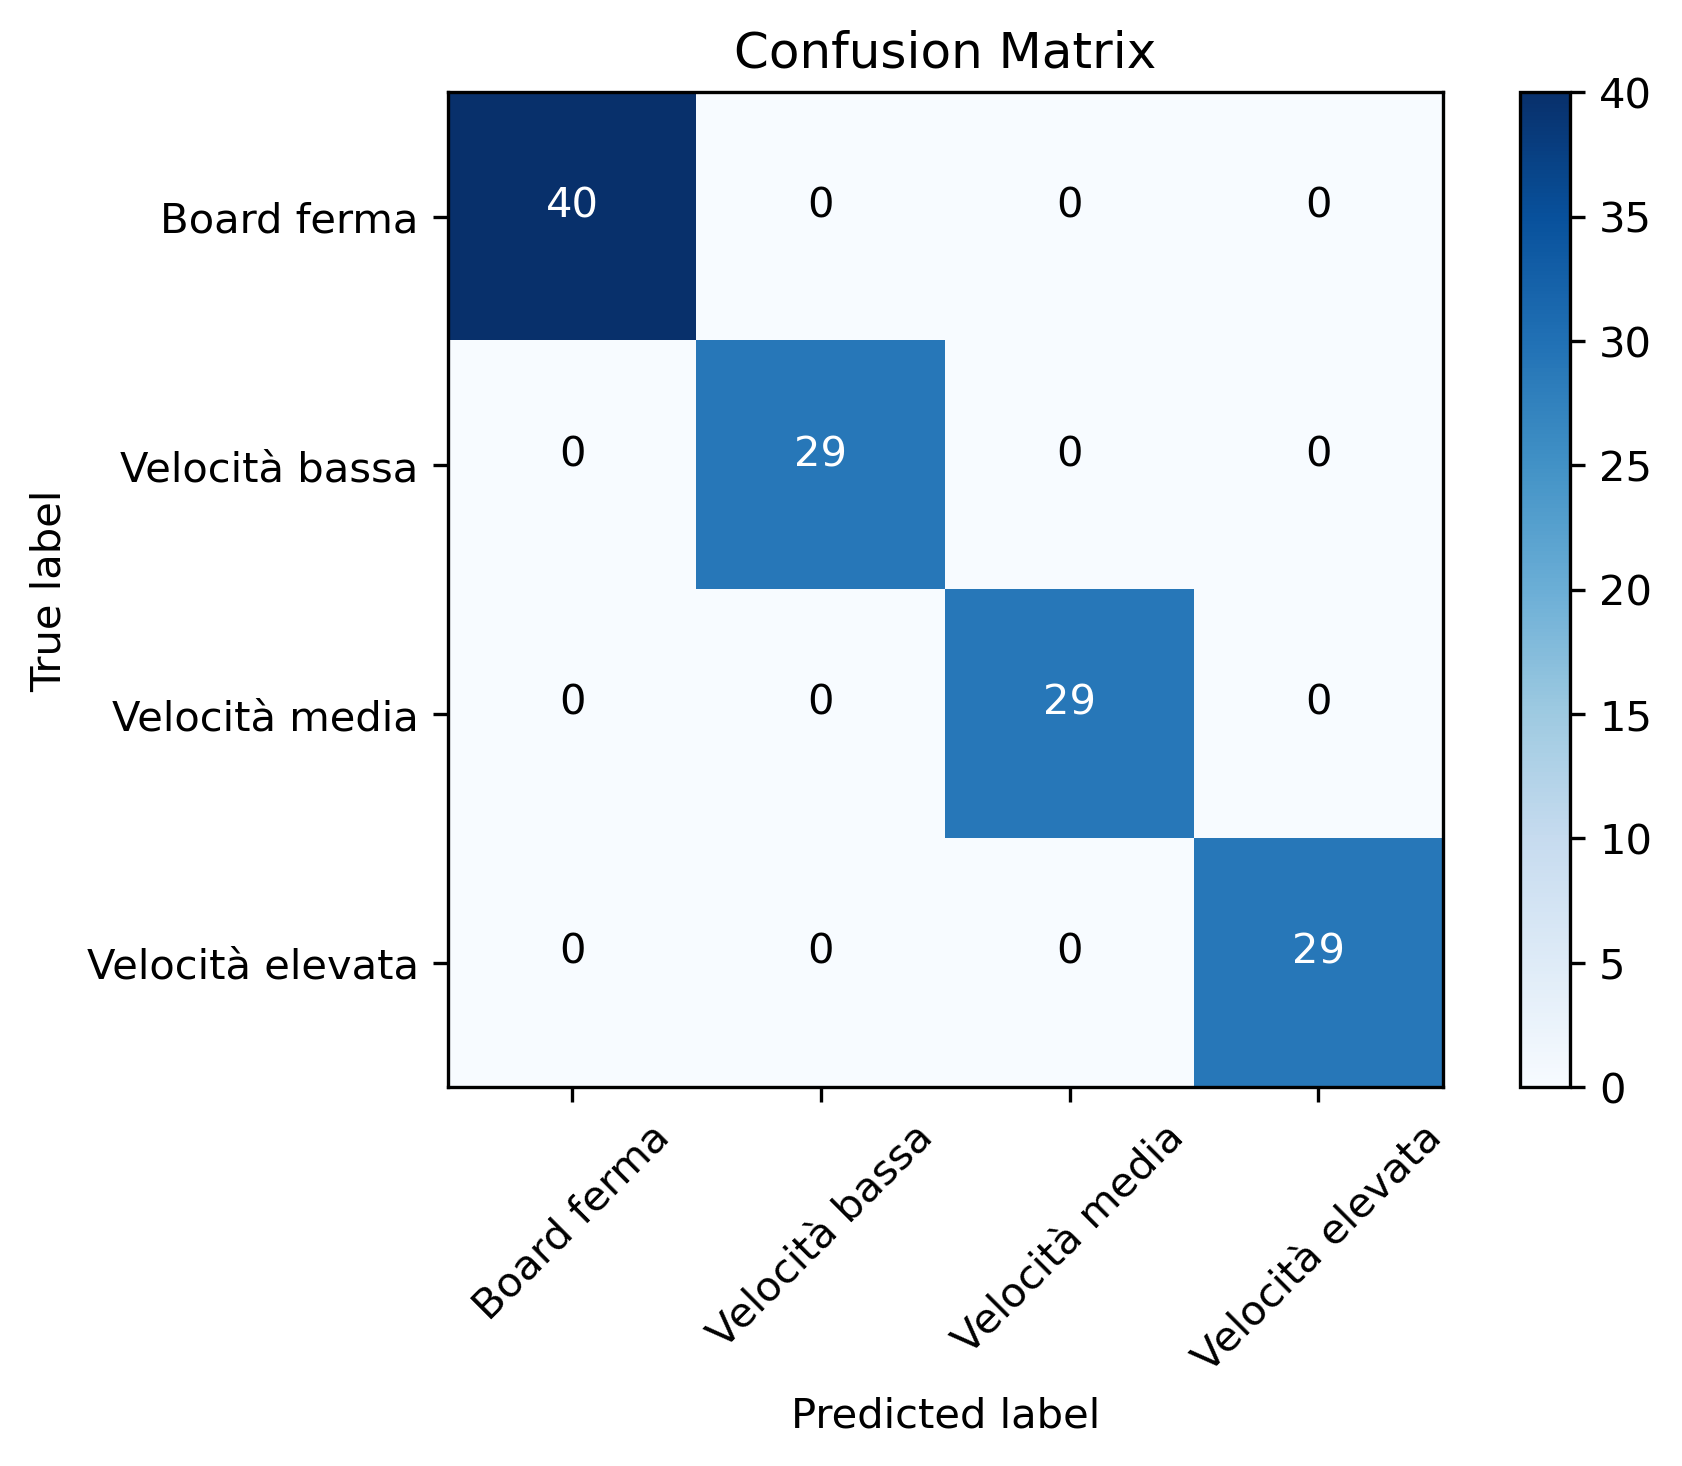

In [17]:
plot_confusion_matrix(cm=matrix, classes=cm_plot_labels, title='Confusion Matrix')

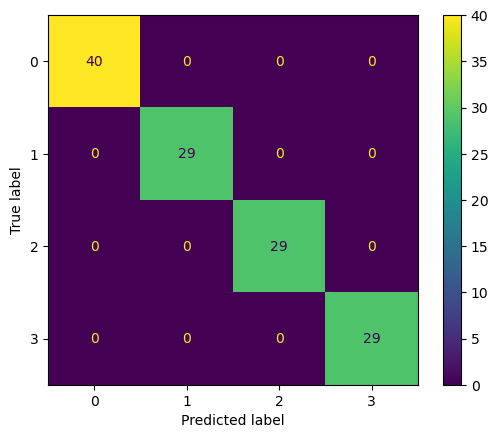

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp = disp.plot()
plt.show() 

In [19]:
from sklearn.metrics import accuracy_score, classification_report

In [20]:
print(f"Classification Report : \n\n{classification_report(y_test, y_pred)}")

Classification Report : 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        40
         1.0       1.00      1.00      1.00        29
         2.0       1.00      1.00      1.00        29
         3.0       1.00      1.00      1.00        29

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

